# Dataset analysis
Understanding the data is essential part of creating models that perform well. We can understand data through data analysis.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit
0,38.942,µg/m3,2018-01-01 00:00:00 +01:00,2018-01-01 01:00:00 +01:00,46.409,µg/m3,0.46168,mg/m3,21.6056,µg/m3
1,52.889,µg/m3,2018-01-01 01:00:00 +01:00,2018-01-01 02:00:00 +01:00,53.467,µg/m3,0.43268,mg/m3,21.1869,µg/m3
2,37.007,µg/m3,2018-01-01 02:00:00 +01:00,2018-01-01 03:00:00 +01:00,37.668,µg/m3,0.39208,mg/m3,16.2845,µg/m3
3,35.837,µg/m3,2018-01-01 03:00:00 +01:00,2018-01-01 04:00:00 +01:00,37.333,µg/m3,0.38628,mg/m3,17.3246,µg/m3
4,34.408,µg/m3,2018-01-01 04:00:00 +01:00,2018-01-01 05:00:00 +01:00,29.130,µg/m3,0.36308,mg/m3,15.5656,µg/m3


In [3]:
print(f'Number of rows: {len(df)}')

Number of rows: 26298


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,25956.0,22.392300,14.358808,0.00260,12.415750,19.768500,28.975500,353.12000
PM2.5 Concentration,25728.0,14.541749,12.478324,0.01220,5.852625,10.847500,19.669000,118.52000
CO Concentration,25640.0,0.384108,0.165666,0.04176,0.265060,0.344636,0.467016,3.29904
NO2 Concentration,25650.0,31.520344,20.845578,1.10093,15.093450,27.236400,43.630850,145.59900


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

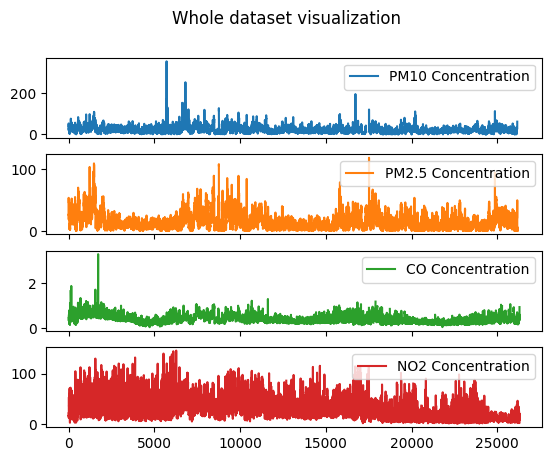

In [5]:
df.plot(subplots=True, title='Whole dataset visualization')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

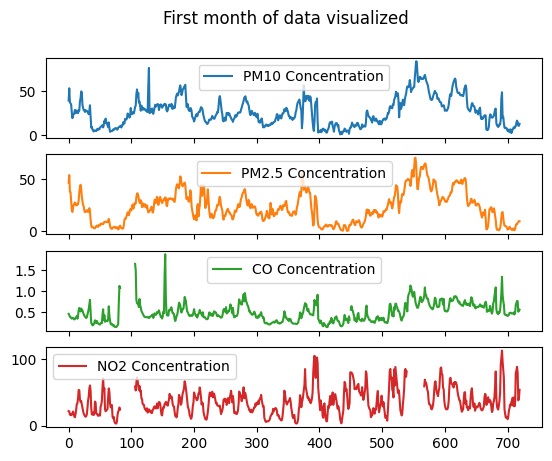

In [6]:
df[:720].plot(subplots=True, title='First month of data visualized')

c:\Users\seboc\OneDrive\Počítač\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

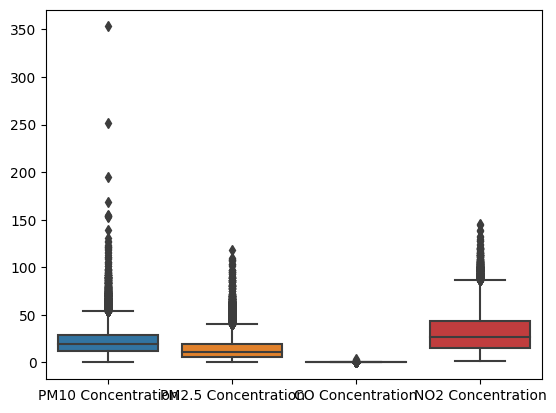

In [7]:
sns.boxplot(data=df)

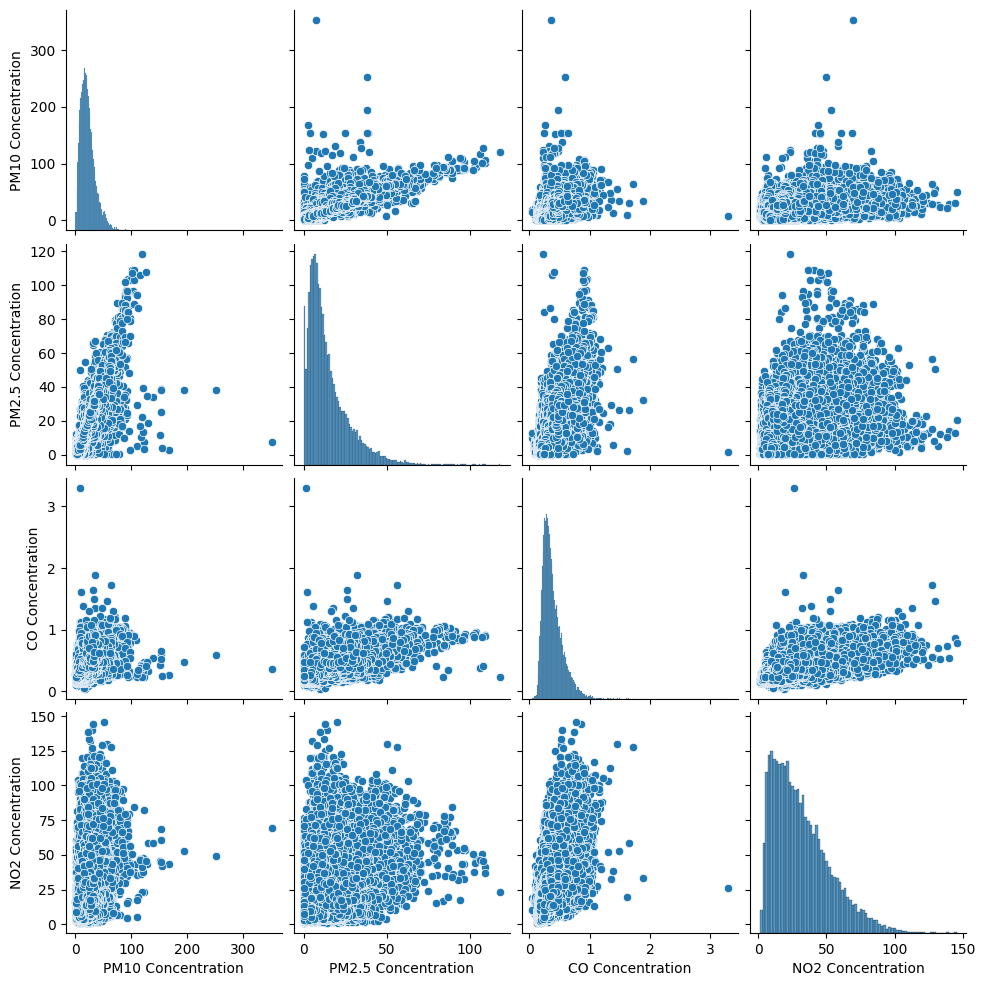

In [8]:
sns.pairplot(data=df)

In [9]:
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']].corr(method='pearson')

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration
PM10 Concentration,1.000000,0.791429,0.517186,0.340900
PM2.5 Concentration,0.791429,1.000000,0.614492,0.238039
CO Concentration,0.517186,0.614492,1.000000,0.602560
NO2 Concentration,0.340900,0.238039,0.602560,1.000000


<AxesSubplot: >

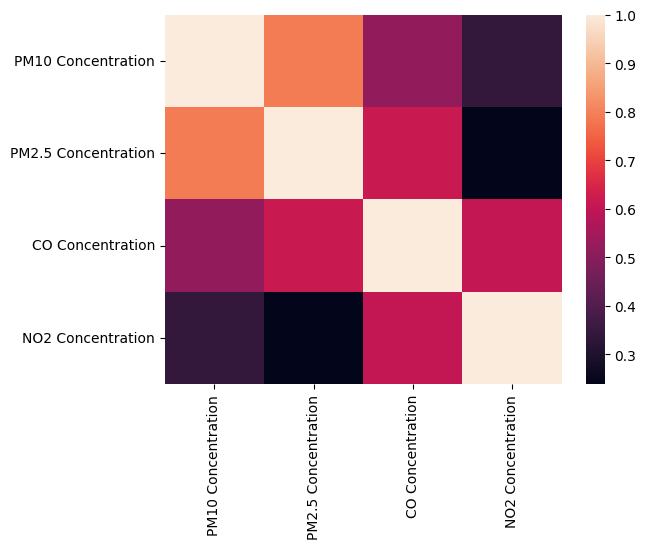

In [10]:
sns.heatmap(data=df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']].corr(method='pearson'))

The table shows that correlation coefficient between any pair of measured data is considerably strong. This means our data is related. We can see particularly strong correlation between PM10 and PM2.5 particles and PM2.5 particles and CO concentration.

In [11]:
nan_rows = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1) > 0)
print(f'Number of rows containing NaN is {nan_rows}/{len(df)} or {round(nan_rows / len(df) * 100, 3)} %')

Number of rows containing NaN is 1752/26298 or 6.662 %


In [12]:
df[df.isna().any(axis = 1)]

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit
83,10.3570,µg/m3,2018-01-04 11:00:00 +01:00,2018-01-04 12:00:00 +01:00,4.0930,µg/m3,NaN,NaN,NaN,NaN
84,8.2579,µg/m3,2018-01-04 12:00:00 +01:00,2018-01-04 13:00:00 +01:00,2.8066,µg/m3,NaN,NaN,NaN,NaN
85,10.6530,µg/m3,2018-01-04 13:00:00 +01:00,2018-01-04 14:00:00 +01:00,2.6694,µg/m3,NaN,NaN,NaN,NaN
86,10.7530,µg/m3,2018-01-04 14:00:00 +01:00,2018-01-04 15:00:00 +01:00,2.4226,µg/m3,NaN,NaN,NaN,NaN
87,14.2640,µg/m3,2018-01-04 15:00:00 +01:00,2018-01-04 16:00:00 +01:00,2.5806,µg/m3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
26293,NaN,NaN,2020-12-17 14:00:00 +01:00,2020-12-17 15:00:00 +01:00,NaN,NaN,0.484880,mg/m3,NaN,NaN
26294,NaN,NaN,2020-12-23 13:00:00 +01:00,2020-12-23 14:00:00 +01:00,NaN,NaN,0.938788,mg/m3,NaN,NaN
26295,NaN,NaN,2020-10-04 11:00:00 +01:00,NaN,NaN,NaN,NaN,NaN,3.39476,µg/m3
26296,NaN,NaN,2020-10-19 15:00:00 +01:00,NaN,NaN,NaN,NaN,NaN,21.31880,µg/m3


# Data cleaning

Dataset will be cleaned using 3 methond:
1. dropping rows with NaN values (later reffered as df_v1)
2. setting NaN values to 0 (later reffered as df_v2)
3. inputing NaN values (later reffered as df_v2)

In [13]:
def timeCleaning(x):
    return x.rsplit(' ', 1)[0]
df['DatetimeBegin'] = df['DatetimeBegin'].apply(timeCleaning)
df.drop(columns='DatetimeEnd', inplace=True)

In [14]:
df_v1 = df.copy()
df_v1.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit'], inplace=True, axis=1)
df_v1 = df_v1.dropna().reset_index()

In [15]:
df_v2 = df.copy()
df_v2.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit'], inplace=True, axis=1)
df_v2 = df_v2.fillna(0)

In [16]:
df_v3 = df.copy()
df_v3.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit'], inplace=True, axis=1)
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df_v1[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']])
df_v3[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']] = imputer.transform(df_v3[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']])
df_v3

,PM10 Concentration,DatetimeBegin,PM2.5 Concentration,CO Concentration,NO2 Concentration
0,38.942000,2018-01-01 00:00:00,46.409000,0.461680,21.605600
1,52.889000,2018-01-01 01:00:00,53.467000,0.432680,21.186900
2,37.007000,2018-01-01 02:00:00,37.668000,0.392080,16.284500
3,35.837000,2018-01-01 03:00:00,37.333000,0.386280,17.324600
4,34.408000,2018-01-01 04:00:00,29.130000,0.363080,15.565600
...,...,...,...,...,...
26293,21.691116,2020-12-17 14:00:00,17.241678,0.484880,38.239336
26294,17.604603,2020-12-23 13:00:00,29.136753,0.938788,67.580143
26295,18.492823,2020-10-04 11:00:00,16.271287,0.290435,3.394760
26296,21.073307,2020-10-19 15:00:00,15.242197,0.350426,21.318800


In [17]:
df_v1_timestamps = pd.to_datetime(df_v1.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')
df_v2_timestamps = pd.to_datetime(df_v2.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')
df_v3_timestamps = pd.to_datetime(df_v3.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')

## Data scaling

In [18]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()

df_v1[:] = scaler1.fit_transform(df_v1)
df_v1.drop(columns='index', inplace=True)
df_v2[:] = scaler2.fit_transform(df_v2)
df_v3[:] = scaler3.fit_transform(df_v3)

In [19]:
df_v1.head()

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration
0,0.110047,0.391508,0.128917,0.141903
1,0.149554,0.451066,0.120014,0.139005
2,0.104566,0.317750,0.107550,0.105078
3,0.101252,0.314923,0.105769,0.112276
4,0.097204,0.245704,0.098647,0.100103


## Data windowing

In [38]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        self.train_set = train_df
        self.val_set = val_df
        self.test_set = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.create_dsets()

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}', f'Input indices: {self.input_indices}', f'Label indices: {self.label_indices}', f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds

    # @property
    def train(self):
        return self.make_dataset(self.train_set)

    # @property
    def val(self):
        return self.make_dataset(self.val_set)

    # @property
    def test(self):
        return self.make_dataset(self.test_set)

    def create_dsets(self):
        self.train = self.train()
        self.val = self.val()
        self.test = self.test()

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, max_subplots=4):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))
        print(len(inputs), len(labels))
        for n in range(max_n):
            plot_col = 'PM10 Concentration'
            if n == 2:
                plot_col = 'PM2.5 Concentration'
            elif n == 3:
                plot_col = 'CO Concentration'
            elif n == 4:
                plot_col = 'NO2 Concentration'
            plot_col_index = self.column_indices[plot_col]
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        print(self.label_columns)

In [39]:
num_features = df_v1.shape[1] # 4

n = len(df_v1)
train_v1 = df_v1[0:int(n*0.7)]
val_v1 = df_v1[int(n*0.7):int(n*0.9)]
test_v1 = df_v1[int(n*0.9):]

dataWin_v1 = WindowGenerator(input_width=24*4, label_width=24, shift=24, train_df=train_v1, val_df=val_v1, test_df=test_v1)

In [40]:
n = len(df_v2)
train_v2 = df_v2[0:int(n*0.7)]
val_v2 = df_v2[int(n*0.7):int(n*0.9)]
test_v2 = df_v2[int(n*0.9):]

dataWin_v2 = WindowGenerator(input_width=24*4, label_width=24, shift=24, train_df=train_v2, val_df=val_v2, test_df=test_v2)

In [41]:
n = len(df_v3)
train_v3 = df_v3[0:int(n*0.7)]
val_v3 = df_v3[int(n*0.7):int(n*0.9)]
test_v3 = df_v3[int(n*0.9):]

dataWin_v3 = WindowGenerator(input_width=24*4, label_width=24, shift=24, train_df=train_v3, val_df=val_v3, test_df=test_v3)

## Model creation and training

In [26]:
model1 = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(24*4, 4), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(96, activation='relu'),
        tf.keras.layers.Reshape([24, num_features])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

model1.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96, 72)            22176     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                1

In [27]:
model2 = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(24*4, 4), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(96, activation='relu'),
        tf.keras.layers.Reshape([24, num_features])
])

model2.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 96, 72)            22176     
                                                                 
 lstm_3 (LSTM)               (None, 48)                23232     
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dropout_2 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               6272      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 96)               

In [28]:
model3 = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(24*4, 4), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(96, activation='relu'),
        tf.keras.layers.Reshape([24, num_features])
])

model3.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 96, 72)            22176     
                                                                 
 lstm_5 (LSTM)               (None, 48)                23232     
                                                                 
 flatten_2 (Flatten)         (None, 48)                0         
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               6272      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 96)               

In [29]:
history1 = model1.fit(dataWin_v1.train, epochs=5, callbacks=[early_stopping])

Epoch 1/5
534/534 [==============================] - 57s 97ms/step - loss: 0.0084 - mean_absolute_error: 0.0617 - root_mean_squared_error: 0.0918 - mean_absolute_percentage_error: 1347.5602
Epoch 2/5
534/534 [==============================] - 54s 101ms/step - loss: 0.0068 - mean_absolute_error: 0.0545 - root_mean_squared_error: 0.0822 - mean_absolute_percentage_error: 1361.6505
Epoch 3/5
534/534 [==============================] - 63s 117ms/step - loss: 0.0066 - mean_absolute_error: 0.0537 - root_mean_squared_error: 0.0813 - mean_absolute_percentage_error: 1368.0657
Epoch 4/5
534/534 [==============================] - 64s 120ms/step - loss: 0.0065 - mean_absolute_error: 0.0531 - root_mean_squared_error: 0.0804 - mean_absolute_percentage_error: 1357.0172
Epoch 5/5
534/534 [==============================] - 66s 124ms/step - loss: 0.0064 - mean_absolute_error: 0.0528 - root_mean_squared_error: 0.0800 - mean_absolute_percentage_error: 1324.0505


In [30]:
history2 = model2.fit(dataWin_v2.train, epochs=5, callbacks=[early_stopping])

Epoch 1/5
572/572 [==============================] - 73s 120ms/step - loss: 0.0087 - mean_absolute_error: 0.0626 - root_mean_squared_error: 0.0935 - mean_absolute_percentage_error: 2218353.5000
Epoch 2/5
572/572 [==============================] - 74s 130ms/step - loss: 0.0071 - mean_absolute_error: 0.0555 - root_mean_squared_error: 0.0840 - mean_absolute_percentage_error: 2267056.0000
Epoch 3/5
572/572 [==============================] - 70s 122ms/step - loss: 0.0069 - mean_absolute_error: 0.0546 - root_mean_squared_error: 0.0830 - mean_absolute_percentage_error: 2257607.2500
Epoch 4/5
572/572 [==============================] - 70s 122ms/step - loss: 0.0068 - mean_absolute_error: 0.0541 - root_mean_squared_error: 0.0822 - mean_absolute_percentage_error: 2252157.0000
Epoch 5/5
572/572 [==============================] - 70s 122ms/step - loss: 0.0067 - mean_absolute_error: 0.0535 - root_mean_squared_error: 0.0816 - mean_absolute_percentage_error: 2232962.0000


In [31]:
history3 = model3.fit(dataWin_v3.train, epochs=5, callbacks=[early_stopping])

Epoch 1/5
572/572 [==============================] - 72s 119ms/step - loss: 0.0082 - mean_absolute_error: 0.0605 - root_mean_squared_error: 0.0903 - mean_absolute_percentage_error: 1245.8848
Epoch 2/5
572/572 [==============================] - 69s 121ms/step - loss: 0.0065 - mean_absolute_error: 0.0533 - root_mean_squared_error: 0.0806 - mean_absolute_percentage_error: 1267.6300
Epoch 3/5
572/572 [==============================] - 72s 126ms/step - loss: 0.0063 - mean_absolute_error: 0.0525 - root_mean_squared_error: 0.0796 - mean_absolute_percentage_error: 1268.1428
Epoch 4/5
572/572 [==============================] - 69s 120ms/step - loss: 0.0062 - mean_absolute_error: 0.0520 - root_mean_squared_error: 0.0789 - mean_absolute_percentage_error: 1288.5375
Epoch 5/5
572/572 [==============================] - 68s 119ms/step - loss: 0.0062 - mean_absolute_error: 0.0517 - root_mean_squared_error: 0.0785 - mean_absolute_percentage_error: 1251.1492


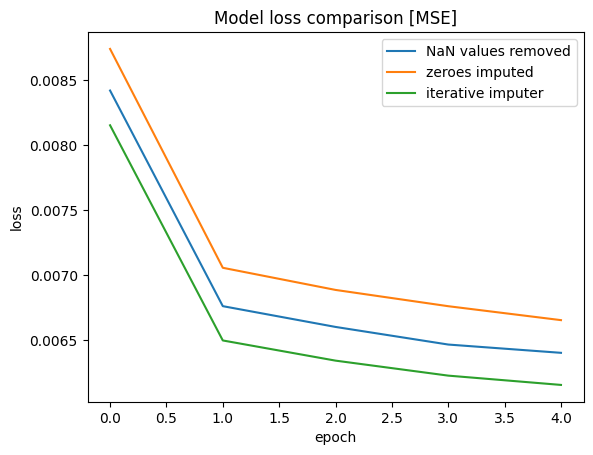

In [32]:
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.title('Model loss comparison [MSE]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['NaN values removed', 'zeroes imputed', 'iterative imputer'])
plt.show()

In [34]:
eval_mae = []
eval_mse = []

eval = model1.evaluate(dataWin_v1.val)
print(f'Mean squared error, mean absolute error: {eval}')
eval_mse.append(eval[0])
eval_mae.append(eval[1])

150/150 [==============================] - 6s 34ms/step - loss: 0.0061 - mean_absolute_error: 0.0560 - root_mean_squared_error: 0.0783 - mean_absolute_percentage_error: 13472.4355
Mean squared error, mean absolute error: [0.0061356499791145325, 0.05598829686641693, 0.0783303901553154, 13472.435546875]


In [35]:
eval = model2.evaluate(dataWin_v2.val)
print(f'Mean squared error, mean absolute error: {eval}')
eval_mse.append(eval[0])
eval_mae.append(eval[1])

161/161 [==============================] - 6s 32ms/step - loss: 0.0058 - mean_absolute_error: 0.0550 - root_mean_squared_error: 0.0764 - mean_absolute_percentage_error: 3294953.0000
Mean squared error, mean absolute error: [0.005833746865391731, 0.055018797516822815, 0.0763789638876915, 3294953.0]


In [36]:
eval = model3.evaluate(dataWin_v3.val)
print(f'Mean squared error, mean absolute error: {eval}')
eval_mse.append(eval[0])
eval_mae.append(eval[1])

161/161 [==============================] - 6s 33ms/step - loss: 0.0054 - mean_absolute_error: 0.0515 - root_mean_squared_error: 0.0733 - mean_absolute_percentage_error: 16438.1484
Mean squared error, mean absolute error: [0.005368256010115147, 0.05147945508360863, 0.07326839119195938, 16438.1484375]


32 32
None


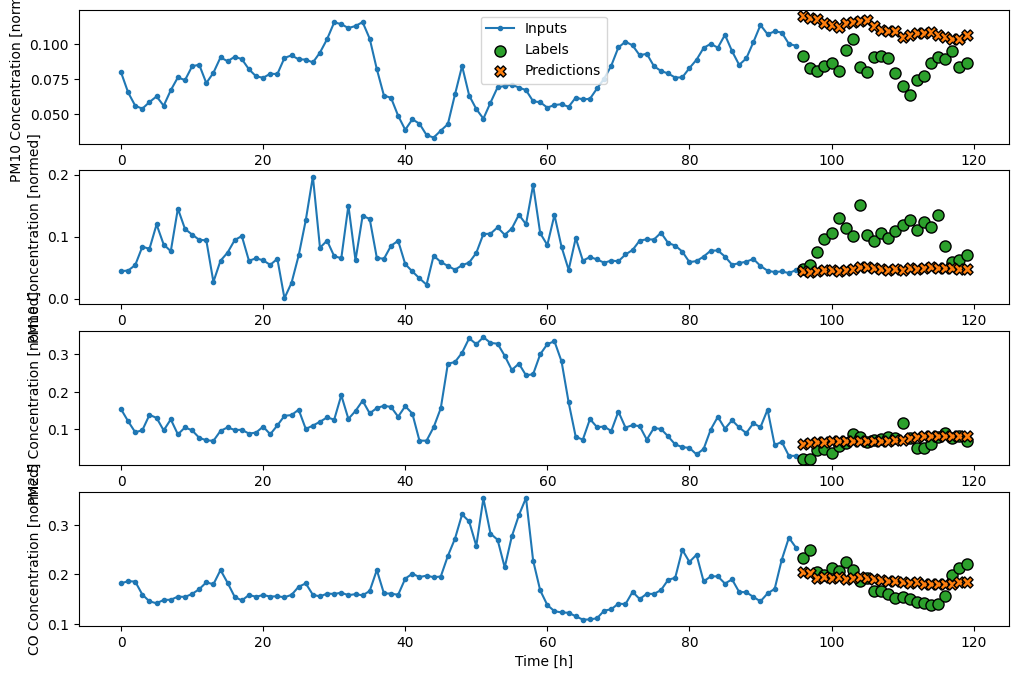

In [42]:
dataWin_v1.plot(model1)


32 32
None


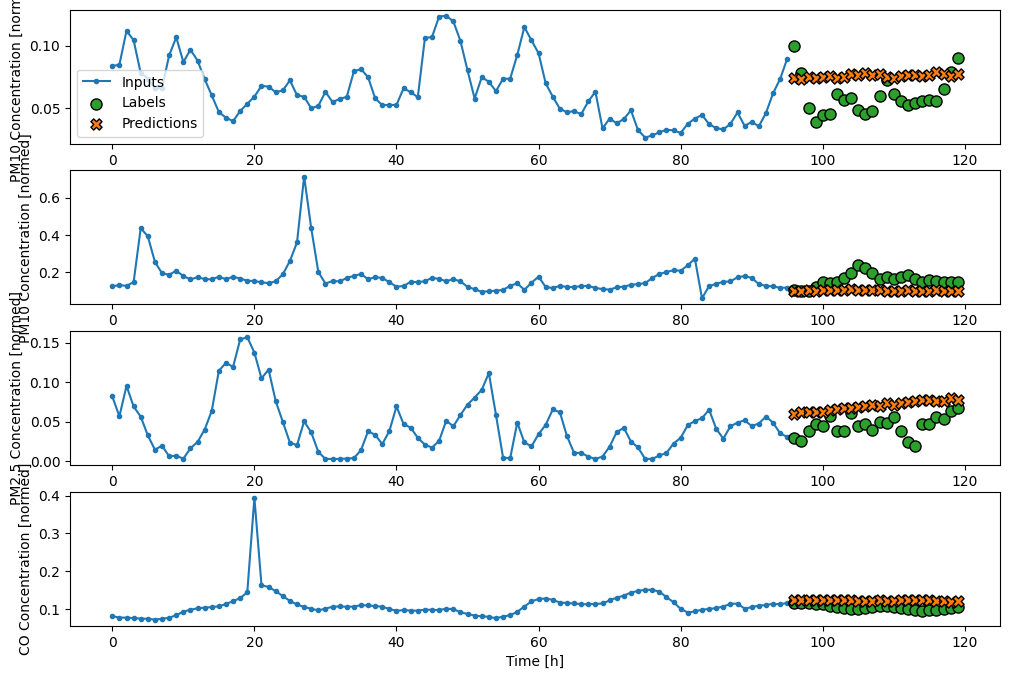

In [43]:
dataWin_v2.plot(model2)

32 32
None


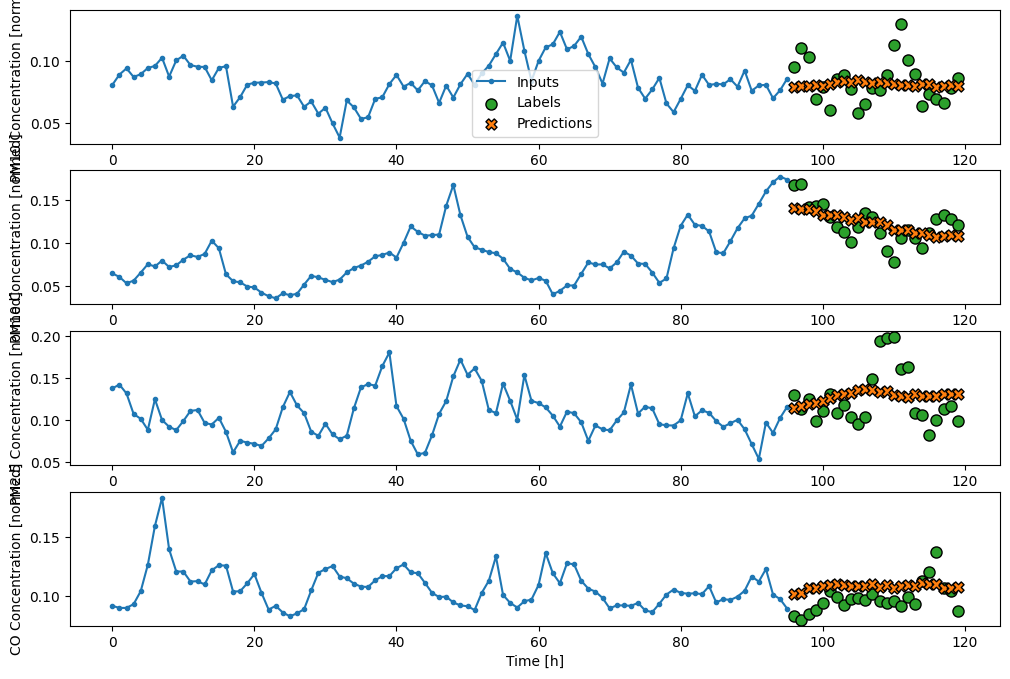

In [44]:
dataWin_v3.plot(model3)